In this tutorial, we solve a nonlinear elasticity problem using the Fourier-Galerkin method implemented in the `xpektra` library. We use hyperelastic material models to define the stress-strain relationship. The problem is solved using a Newton-Krylov solver with a conjugate gradient method as the linear solver.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")

import jax.numpy as jnp
from jax import Array

import numpy as np

In [ ]:
from xpektra import SpectralSpace, make_field
from xpektra.transform import FFTTransform
from xpektra.scheme import RotatedDifference
from xpektra.spectral_operator import SpectralOperator
from xpektra.projection_operator import GalerkinProjection

from xpektra.solvers.nonlinear import (  # noqa: E402
    NewtonSolver,
    conjugate_gradient,
)

from functools import partial
import equinox as eqx
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Constructing a dual phase RVE

We define a dual-phase RVE with a square inclusion in a square matrix. The inclusion has different material properties than the matrix.

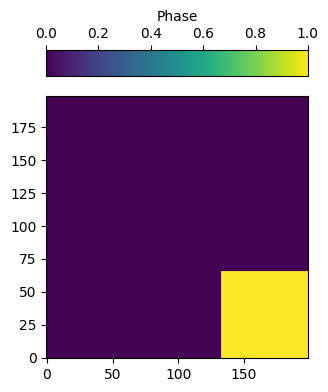

In [95]:
ndim = 2
N = 199
length = 1.0

r = int(N / 3)

structure = np.zeros((N, N))
structure[:r, -r:] +=  np.ones((r, r))

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
cb = plt.imshow(structure, origin="lower", cmap="viridis")
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb, cax=cax, label=r"Phase", orientation="horizontal", location="top"
)

plt.show()

The square inclusion is stiffer than the matrix. The material properties are defined using the St. Venant-Kirchhoff hyperelastic model.

In [5]:
E1 = 0.57
E2 = 5.7   
nu1 = 0.386
nu2 = 0.386

lambda1 = E1 * nu1 / ((1 + nu1) * (1 - 2 * nu1))
mu1 = E1 / (2 * (1 + nu1))

lambda2 = E2 * nu2 / ((1 + nu2) * (1 - 2 * nu2))
mu2 = E2 / (2 * (1 + nu2))


lambdas = lambda1 * (1.0 - structure) + lambda2 * structure
mus = mu1 * (1.0 - structure) + mu2 * structure

## Defining the Operators

In order to define the Fourier-Galerkin operator, we first define the spectral space, the transform operators, and the spectral operators. We use the `SpectralSpace` class to define the spectral space, the `Fourier` class to define the FFT and IFFT operators, and the `RotatedDifference` class to define the spatial operators.

Finally we define the Spectral Operators using the `SpectralOperator` class which takes the spectral space and the spatial operators as input.


In [4]:
fft_transform = FFTTransform(dim=ndim)
space = SpectralSpace(
    lengths=(length,) * ndim, shape=structure.shape, transform=fft_transform
)
rotated_scheme = RotatedDifference(space=space)

op = SpectralOperator(
    scheme=rotated_scheme,
    space=space,
)

Ghat = GalerkinProjection(scheme=rotated_scheme)
dofs_shape = make_field(dim=ndim, shape=structure.shape, rank=2).shape

The strain energy density function for the St. Venant-Kirchhoff model is given by:

$$\Psi = \frac{1}{2} \lambda (\text{tr}(E))^2 + \mu \text{tr}(E^2)$$

where $E$ is the Green-Lagrange strain tensor, and $\lambda$ and $\mu$ are the Lamé parameters. The Green-Lagrange strain tensor is defined as:

$$E = \frac{1}{2} (F^T F - I)$$

where $F$ is the deformation gradient tensor and $I$ is the identity tensor.

The first Piola-Kirchhoff stress tensor $P$ is derived from the strain energy density function as: 

$$P = \frac{\partial \Psi}{\partial F}$$

In [6]:
i = jnp.eye(ndim)
I = make_field(dim=ndim, shape=structure.shape, rank=2) + i

@eqx.filter_jit
def green_lagrange_strain(F: Array) -> Array:
    return 0.5 * (op.dot(op.trans(F), F) - I)


@eqx.filter_jit
def strain_energy(F_flat: Array) -> float:
    F = F_flat.reshape(dofs_shape)
    E = green_lagrange_strain(F)
    E = 0.5 * (E + op.trans(E))
    energy = 0.5 * jnp.multiply(lambdas, op.trace(E) ** 2) + jnp.multiply(
        mus, op.trace(op.dot(E, E))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)


## Defining the Residual and Jacobian Functions

We now define the residual function and the Jacobian function for the Newton solver. The residual function computes the residual of the problem based on the given macro strain. It takes only the flattened vector of fluctuation strain and a macro strain. The Jacobian function represents the Jacobian-vector product.

The total deformation gradient is given as

$$F = \tilde{F} + F_\text{macro}^{i}  $$

where $\tilde{F}$ is the fluctuation strain and $\mathbf{F}_\text{macro}^{i}$ is the applied macro strain at iteration $i$.

The residual is given as

$$R(\tilde{F}, F_\text{macro}) = \mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}(\tilde{F} + F_\text{macro}^{i})) \right) $$

where $\mathbb{G}$ is the Fourier-Galerkin operator defined earlier, $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the FFT and IFFT operators respectively, and $\mathbf{\sigma}$ is the stress tensor computed from the strain energy function defined earlier.

We can define the residual at $\tilde{F} + \Delta \tilde{F}$ as

$$R(\tilde{\mathbf{F}} + \Delta \tilde{\mathbf{F}}, F_\text{macro}) = \mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\mathbf{\sigma}(\tilde{F} + \Delta \tilde{\mathbf{F}} + F_\text{macro}^{i})) \right) $$

USing the Taylor expansion, we can write

$$R(\tilde{\mathbf{F}} + \Delta \tilde{\mathbf{F}}, F_\text{macro}) \approx R(\tilde{\mathbf{F}}, F_\text{macro}) + \frac{\partial R}{\partial \tilde{\mathbf{F}}} \Delta \tilde{\mathbf{F}} $$

Below we define the residual function and the Jacobian function using the above equations.

We use `op.forward` and `op.inverse` methods to apply the FFT and IFFT operators respectively.

We compute the tangents at $\Delta \tilde{F}$ as Jacobian-vector products _i.e.,_

$$\frac{\partial R}{\partial \tilde{F}} \Delta \tilde{F} = \mathcal{F}^{-1} \left( \mathbb{G}:\mathcal{F}(\sigma(\Delta \tilde{F})) \right) $$

In [73]:
@eqx.filter_jit
def residual_fn(eps_fluc_flat: Array, macro_strain: float) -> Array:
    """
    A function that computes the residual of the problem based on the given macro strain.
    It takes only the flattened vector of fluctuation strain and a macro strain.

    Args:
        eps_fluc_flat: Flattened vector of fluctuation strain.
        macro_strain: Macro strain.

    Returns:
        Residual field.
    """

    eps_fluc = eps_fluc_flat.reshape(dofs_shape)
    eps_macro = jnp.zeros(dofs_shape)
    eps_macro = eps_macro.at[:, :, 0, 0].set(macro_strain)
    eps_macro = eps_macro.at[:, :, 1, 1].set(macro_strain)
    eps_total = eps_fluc + eps_macro
    eps_flat = eps_total.reshape(-1)
    sigma = compute_stress(eps_flat)
    residual_field = op.inverse(Ghat.project(op.forward(sigma.reshape(dofs_shape))))
    return jnp.real(residual_field).reshape(-1)

@eqx.filter_jit
def jacobian_fn(deps_fluc_flat: Array, eps_fluc_flat: Array) -> Array:

    deps_flat = deps_fluc_flat.reshape(-1)
    eps_fluc = eps_fluc_flat.reshape(-1)
    dsigma = jax.jvp(compute_stress, (eps_fluc,), (deps_flat,))[1]
    jvp_field = op.inverse(
        Ghat.project(op.forward(dsigma.reshape(dofs_shape)))
    )
    return jnp.real(jvp_field).reshape(-1)


We definre the Newton-Krylov solver using the `NewtonKrylovSolver` class. We set the maximum number of iterations and the tolerance for convergence. We also define the linear solver to be used within the Newton-Krylov solver, which is the conjugate gradient method in this case.

In [42]:
solver = NewtonSolver(
    tol=1e-8,
    max_iter=20,
    krylov_solver=conjugate_gradient,
    krylov_tol=1e-8,
    krylov_max_iter=20,
)

In [74]:
applied_strains = jnp.linspace(0.0, 0.01, num=6)
F_fluc_init = jnp.array(make_field(dim=ndim, shape=structure.shape, rank=2))
F_fluc_init = F_fluc_init.at[:, :, 0, 0].set(1.0)
F_fluc_init = F_fluc_init.at[:, :, 1, 1].set(1.0)


for inc, macro_defo in enumerate(applied_strains):
    print(f"Increment {inc+1}/{len(applied_strains)}: Applied strain = {macro_defo}")
    # solving for elasticity
    residual = jax.jit(partial(residual_fn, macro_strain=macro_defo))
    jacobian = jax.jit(partial(jacobian_fn, eps_fluc_flat=F_fluc_init.reshape(-1),))# gradient=residual))
    
    b = -residual(F_fluc_init.reshape(-1))

    dF_fluc = solver.solve(
        x=F_fluc_init.reshape(-1),
        b=b,
        f=residual,
        jac=jacobian,
    )

    F_fluc = F_fluc_init + dF_fluc.reshape(dofs_shape) - jnp.eye(ndim)[None, None, :, :]  # remove identity part
    F_fluc_init = F_fluc

    F = F_fluc + jnp.eye(ndim)[None, None, :, :] * ( macro_defo)

P = compute_stress(F.reshape(-1)).reshape(dofs_shape)


Increment 1/6: Applied strain = 0.0
Converged, Residual value : 0.0
Increment 2/6: Applied strain = 0.002
Converged, Residual value : 8.947782934727865e-09
Increment 3/6: Applied strain = 0.004
Converged, Residual value : 9.26545625883322e-09
Increment 4/6: Applied strain = 0.006
Converged, Residual value : 7.997564774594936e-09
Increment 5/6: Applied strain = 0.008
Converged, Residual value : 3.2928063710209945e-09
Increment 6/6: Applied strain = 0.01
Converged, Residual value : 7.866176824734989e-09


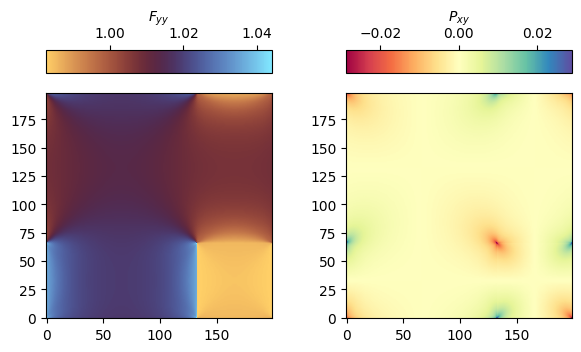

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), layout="constrained")

cb = ax1.imshow(F.at[:, :, 1, 1].get(), cmap="managua", origin="lower")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb, cax=cax, label=r"$F_{yy}$", orientation="horizontal", location="top"
)


cb = ax2.imshow(P.at[:, :, 0, 1].get(), cmap="Spectral", origin="lower")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("top", size="10%", pad=0.2)
fig.colorbar(
    cb, cax=cax, label=r"$P_{xy}$", orientation="horizontal", location="top"
)


plt.show()
